## PYTHON code accompanying the paper:
###   A tutorial on generalized eigendecomposition for denoising, contrast enhancement, and dimension reduction in multichannel electrophysiology

Mike X Cohen (mikexcohen@gmail.com)
 
The files emptyEEG.mat, filterFGx.m, and topoplotindie.m need to be in 
the current directory. 

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D

from filterFGxfun import filterFGx
from pytopo import topoplotIndie

# import jade

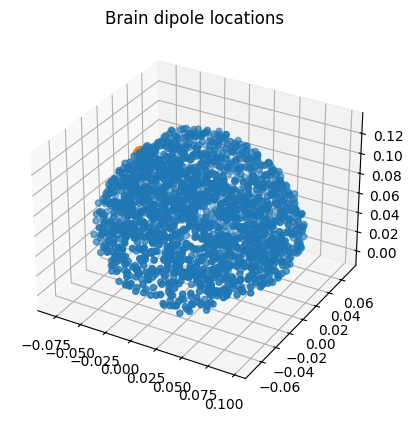

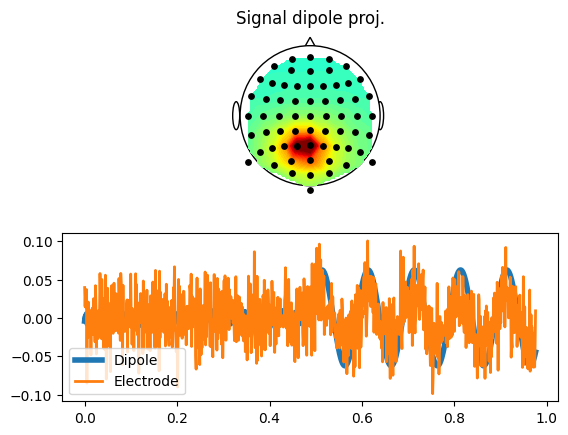

In [6]:
## preliminary

# mat file containing EEG, leadfield and channel locations
matfile = sio.loadmat('emptyEEG')
lf = matfile['lf'][0, 0]
EEG = matfile['EEG'][0, 0]

diploc = 108

# normal dipoles (normal to the surface of the cortex)
lf_GainN = np.zeros((64, 2004))
for i in range(3):
    lf_GainN += lf['Gain'][:, i, :] * lf['GridOrient'][:, i]


### simulate the data
dipole_data = 1 * np.random.randn(lf['Gain'].shape[2], 1000)
# add signal to second half of dataset
dipole_data[diploc, 500:] = 15 * np.sin(2 * np.pi * 10 * np.arange(500) / EEG['srate'])
# project dipole data to scalp electrodes
EEG['data'] = lf_GainN @ dipole_data
# meaningless time series
EEG['times'] = np.squeeze(np.arange(EEG['data'].shape[1]) / EEG['srate'])


# plot brain dipoles
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lf['GridLoc'][:, 0], lf['GridLoc'][:, 1], lf['GridLoc'][:, 2], 'bo')
ax.scatter(
    lf['GridLoc'][diploc, 0],
    lf['GridLoc'][diploc, 1],
    lf['GridLoc'][diploc, 2],
    marker='o',
    s=100,
)
plt.title('Brain Dipole Locations')
plt.show()

_, axs = plt.subplots(2, 1)
topoplotIndie(lf_GainN[:, diploc], EEG['chanlocs'], 'Signal dipole proj.', axs[0])

axs[1].plot(
    EEG['times'],
    dipole_data[diploc, :] / np.linalg.norm(dipole_data[diploc, :]),
    linewidth=4,
    label='Dipole',
)
axs[1].plot(
    EEG['times'],
    EEG['data'][30, :] / np.linalg.norm(EEG['data'][30, :]),
    linewidth=2,
    label='Electrode',
)
axs[1].legend()
plt.show()

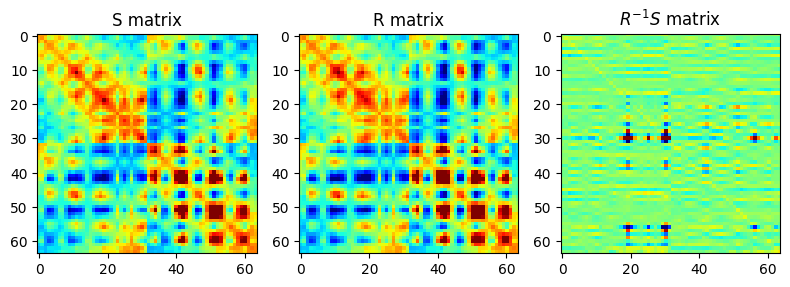

In [7]:
## Create covariance matrices

# compute covariance matrix R is first half of data
tmpd = EEG['data'][:, :500]
covR = np.cov(tmpd)

# compute covariance matrix S is second half of data
tmpd = EEG['data'][:, 500:]
covS = np.cov(tmpd)


### plot the two covariance matrices
_, axs = plt.subplots(1, 3, figsize=(8, 4))

# S matrix
axs[0].imshow(covS, vmin=-1e6, vmax=1e6, cmap='jet')
axs[0].set_title('S matrix')

# R matrix
axs[1].imshow(covR, vmin=-1e6, vmax=1e6, cmap='jet')
axs[1].set_title('R matrix')

# R^{-1}S
axs[2].imshow(np.linalg.inv(covR) @ covS, vmin=-10, vmax=10, cmap='jet')
axs[2].set_title('$R^{-1}S$ matrix')

plt.tight_layout()
plt.show()

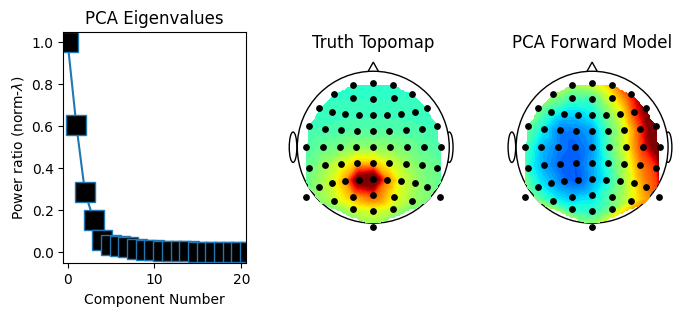

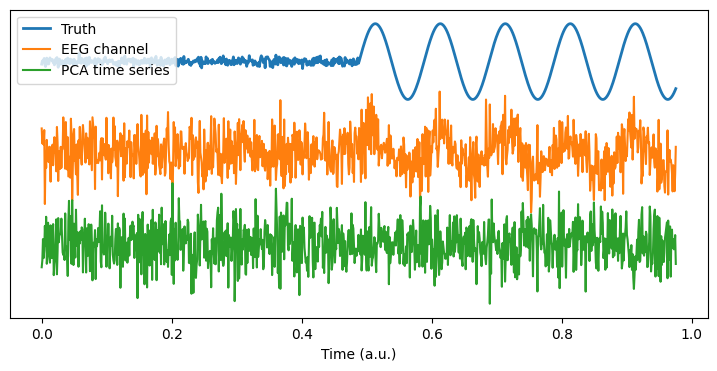

In [12]:
## Dimension compression via PCA

# PCA
evals, evecs = scipy.linalg.eigh(covS + covR)

# sort eigenvalues/vectors
sidx = np.argsort(evals)[::-1]
evals = evals[sidx]
evecs = evecs[:, sidx]


# plot the eigenspectrum
_, axs = plt.subplots(1, 3, figsize=(8, 3))
axs[0].plot(evals / np.max(evals), 's-', markersize=15, markerfacecolor='k')
axs[0].set_xlim([-0.5, 20.5])
axs[0].set_title('PCA Eigenvalues')
axs[0].set_xlabel('Component Number')
axs[0].set_ylabel(r'Power ratio (norm-$\lambda$)')

# filter forward model
filt_topo = evecs[:, 0]

# Eigenvector sign
se = np.argmax(np.abs(filt_topo))
filt_topo = filt_topo * np.sign(filt_topo[se])

# plot the maps
topoplotIndie(lf_GainN[:, diploc], EEG['chanlocs'], 'Truth Topomap', axs[1])
topoplotIndie(filt_topo, EEG['chanlocs'], 'PCA Forward Model', axs[2])

plt.show()


# component time series is eigenvector as spatial filter for data
comp_ts = evecs[:, 0].T @ EEG['data']


# normalize time series (for visualization)
dipl_ts = dipole_data[diploc, :] / np.linalg.norm(dipole_data[diploc, :])
comp_ts = comp_ts / np.linalg.norm(comp_ts)
chan_ts = EEG['data'][30, :] / np.linalg.norm(EEG['data'][30, :])


# plot the time series
plt.figure(figsize=(9, 4))
plt.plot(EEG['times'], 0.3 + dipl_ts, linewidth=2, label='Truth')
plt.plot(EEG['times'], 0.15 + chan_ts, label='EEG channel')
plt.plot(EEG['times'], comp_ts, label='PCA time series')
plt.legend(loc='upper left')
plt.yticks([])
plt.xlabel('Time (a.u.)')
plt.show()

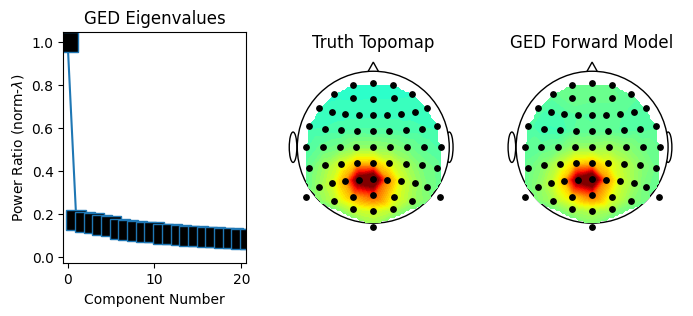

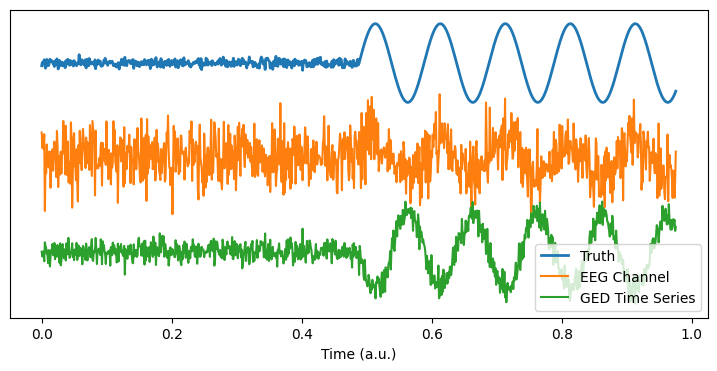

In [14]:
## Source separation via GED

# GED
evals, evecs = scipy.linalg.eigh(covS, covR)

# sort eigenvalues/vectors
sidx = np.argsort(evals)[::-1]
evals = evals[sidx]
evecs = evecs[:, sidx]


# plot the eigenspectrum
_, axs = plt.subplots(1, 3, figsize=(8, 3))
axs[0].plot(evals / np.max(evals), 's-', markersize=15, markerfacecolor='k')
axs[0].set_xlim([-0.5, 20.5])
axs[0].set_title('GED Eigenvalues')
axs[0].set_xlabel('Component Number')
axs[0].set_ylabel(r'Power Ratio (norm-$\lambda$)')

# filter forward model
filt_topo = evecs[:, 0].T @ covS

# Eigenvector sign
se = np.argmax(np.abs(filt_topo))
filt_topo = filt_topo * np.sign(filt_topo[se])

# plot the maps
topoplotIndie(lf_GainN[:, diploc], EEG['chanlocs'], 'Truth Topomap', axs[1])
topoplotIndie(filt_topo, EEG['chanlocs'], 'GED Forward Model', axs[2])

plt.show()


# component time series is eigenvector as spatial filter for data
comp_ts = evecs[:, 0].T @ EEG['data']


# normalize time series (for visualization)
comp_ts = comp_ts / np.linalg.norm(comp_ts)


# plot the time series
plt.figure(figsize=(9, 4))
plt.plot(EEG['times'], 0.3 + dipl_ts, linewidth=2, label='Truth')
plt.plot(EEG['times'], 0.15 + chan_ts, label='EEG Channel')
plt.plot(EEG['times'], comp_ts, label='GED Time Series')
plt.legend()
plt.yticks([])
plt.xlabel('Time (a.u.)')
plt.show()

# Example GED in richer data

In [ ]:
# The above simulation is overly simplistic. The goal of
# this section is to simulate data that shares more
# characteristics to real EEG data, including non-sinusoidal
# rhythms, background noise, and multiple trials.

# This code will simulate resting-state that has been segmented
# into 2-second non-overlapping epochs.

In [15]:
### simulate the data

# signal parameters in Hz
peakfreq = 10  # "alpha"
fwhm = 5  # full-width at half-maximum around the alpha peak


# EEG parameters for the simulation
EEG['srate'] = 500  # sampling rate in Hz
EEG['pnts'] = 2 * EEG['srate']  # each data segment is 2 seconds
EEG['trials'] = 50
EEG['data'] = np.zeros((EEG['nbchan'][0][0], EEG['pnts'], EEG['trials']))


### create frequency-domain Gaussian
hz = np.linspace(0, EEG['srate'], EEG['pnts'])
s = fwhm * (2 * np.pi - 1) / (4 * np.pi)  # normalized width
x = hz - peakfreq  # shifted frequencies
fg = np.exp(-0.5 * (x / s) ** 2)  # gaussian


# loop over trials and generate data
for triali in range(EEG['trials']):

    # random Fourier coefficients
    fc = np.random.rand(EEG['pnts']) * np.exp(
        1j * 2 * np.pi * np.random.rand(1, EEG['pnts'])
    )

    # taper with the Gaussian
    fc = fc * fg

    # back to time domain to get the source activity
    source_ts = 2 * np.real(np.fft.ifft(fc)) * EEG['pnts']

    # simulate dipole data: all noise and replace target dipole with source_ts
    dipole_data = np.random.randn(np.shape(lf_GainN)[1], EEG['pnts'])
    dipole_data[diploc, :] = 0.5 * source_ts
    # Note: the source time series has low amplitude to highlight the
    # sensitivity of GED. Increasing this gain to, e.g., 1 will show
    # accurate though noiser reconstruction in the channel data.

    # now project the dipole data through the forward model to the electrodes
    EEG['data'][:, :, triali] = lf_GainN @ dipole_data

In [16]:
## topoplot of alpha power

channelpower = np.abs(np.fft.fft(EEG['data'], axis=1)) ** 2
channelpowerAve = np.mean(channelpower, axis=2)

# vector of frequencies
hz = np.linspace(0, EEG['srate'] / 2, EEG['pnts'] // 2 + 1)

In [17]:
## Create a covariance tensor (one covmat per trial)

# filter the data around 10 Hz
alphafilt = copy.deepcopy(EEG['data'])
for ti in range(int(EEG['trials'])):
    tmdat = EEG['data'][:, :, ti]
    alphafilt[:, :, ti] = filterFGx(tmdat, EEG['srate'], 10, 4)[0]

# initialize covariance matrices (one for each trial)
allCovS = np.zeros((EEG['trials'], EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
allCovR = np.zeros((EEG['trials'], EEG['nbchan'][0][0], EEG['nbchan'][0][0]))


# loop over trials (data segments) and compute each covariance matrix
for triali in range(EEG['trials']):

    # cut out a segment
    tmpdat = alphafilt[:, :, triali]

    # mean-center
    tmpdat = tmpdat - np.mean(tmpdat, axis=1, keepdims=True)

    # add to S tensor
    allCovS[triali, :, :] = tmpdat @ tmpdat.T / EEG['pnts']

    # repeat for broadband data
    tmpdat = EEG['data'][:, :, triali]
    tmpdat = tmpdat - np.mean(tmpdat, axis=1, keepdims=True)
    allCovR[triali, :, :] = tmpdat @ tmpdat.T / EEG['pnts']

In [18]:
## illustration of cleaning covariance matrices

# clean R
meanR = np.mean(allCovR, axis=0)  # average covariance
dists = np.zeros(EEG['trials'])  # vector of distances to mean
for segi in range(EEG['trials']):
    r = allCovR[segi, :, :]
    # Euclidean distance
    dists[segi] = np.sqrt(np.sum((r.reshape(1, -1) - meanR.reshape(1, -1)) ** 2))

# compute zscored distances
distsZ = (dists - np.mean(dists)) / np.std(dists)

# finally, average trial-covariances together, excluding outliers
covR = np.mean(allCovR[distsZ < 3, :, :], axis=0)


## Normally you'd repeat the above for S; ommitted here for simplicity
covS = np.mean(allCovS, axis=0)

In [19]:
## now for the GED

### NOTE: You can test PCA on these data by using only covS, or only covR,
#         in the eig() function.

# eig and sort
evals, evecs = scipy.linalg.eigh(covS, covR)
sidx = np.argsort(evals)[::-1]
evals = evals[sidx]
evecs = evecs[:, sidx]


### compute the component time series
# for the multiplication, the data need to be reshaped into 2D
data2D = np.reshape(EEG['data'], (EEG['nbchan'][0][0], -1), order='F')
compts = evecs[:, 0].T @ data2D
# and then reshaped back into trials
compts = np.reshape(compts, (EEG['pnts'], EEG['trials']), order='F')

### power spectrum
comppower = np.abs(np.fft.fft(compts, axis=0)) ** 2
comppowerAve = np.mean(comppower, axis=1)

### component map
compmap = evecs[:, 0].T @ covS
# flip map sign
se = np.argmax(np.abs(compmap))
compmap = compmap * np.sign(compmap[se])

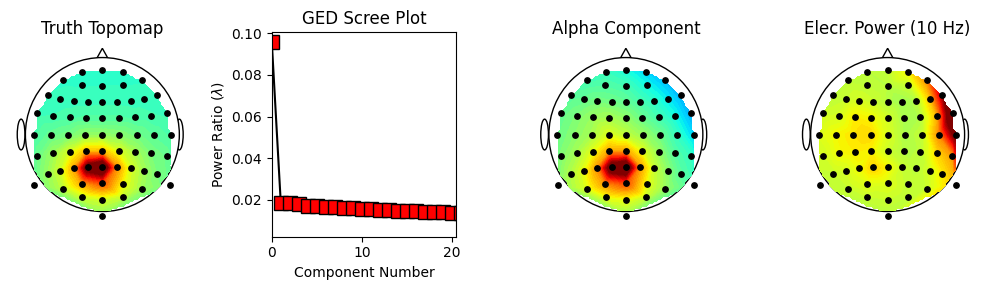

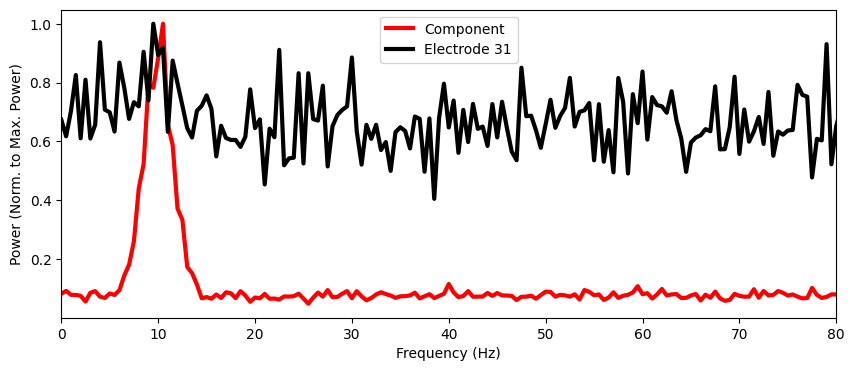

In [22]:
## visualization

_, axs = plt.subplots(1, 4, figsize=(10, 3))

topoplotIndie(lf_GainN[:, diploc], EEG['chanlocs'], 'Truth Topomap', axs[0])

axs[1].plot(evals, 'ks-', markersize=10, markerfacecolor='r')
axs[1].set_xlim([0, 20.5])
axs[1].set_title('GED Scree Plot')
axs[1].set_xlabel('Component Number')
axs[1].set_ylabel(r'Power Ratio ($\lambda$)')
# Note that the max eigenvalue is <1,
# because R has more overall energy than S.

# GED component
topoplotIndie(compmap, EEG['chanlocs'], 'Alpha Component', axs[2])

# channel 10 Hz power
where10 = np.argmin(np.abs(hz - 10))
topoplotIndie(
    channelpowerAve[:, where10], EEG['chanlocs'], 'Elecr. Power (10 Hz)', axs[3]
)
plt.tight_layout()
plt.show()


# spectra
plt.figure(figsize=(10, 4))
plt.plot(
    hz,
    comppowerAve[: len(hz)] / np.max(comppowerAve[: len(hz)]),
    'r',
    linewidth=3,
    label='Component',
)
plt.plot(
    hz,
    channelpowerAve[30, : len(hz)] / np.max(channelpowerAve[30, : len(hz)]),
    'k',
    linewidth=3,
    label='Electrode 31',
)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (Norm. to Max. Power)')
plt.xlim([0, 80])
plt.show()